In [76]:
#This is a starting point
#uncomment below to install merlin library
#!pip install merlin, nvtabular, merlin.models
#I had to downgrade keras to 12.2.0 there maybe issues regarding tensorflow in the future
#run lines below if you have also have an error ab not finding a keras package

#pip uninstall keras
#pip install keras==2.12.0


#These are the same imports from
#https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb
import os
import pandas as pd
import numpy as np
import nvtabular as nvt
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import polars as pl

from sklearn.model_selection import train_test_split

from merlin.models.utils.example_utils import workflow_fit_transform
import merlin.io
import tensorflow as tf

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
from nvtabular.ops import *
from merlin.core.utils import download_file
from merlin.schema.tags import Tags

In [77]:
pd.set_option('display.max_columns', None)

In [78]:
def read_target_sample(file_path, sample_frac = 1, rand = 101, order_weight = 1, added_weight = .5):
    df = pd.read_csv(file_path).dropna() 
    #After cleaning should not need dropna()
    df['TARGET'] = 0
    #Different values for different event_names
    df.loc[df['EVENT_NAME'] == 'order', 'TARGET'] = order_weight
    df.loc[df['EVENT_NAME'] == 'product_added', 'TARGET'] = added_weight

    df = df[df['TARGET'] > 0]
    df = df[df['COUNTRY'] == 'United States']
    df = df.sample(40000, random_state = rand)
    return df

# Cleaning

# TRANSFORM USER DF

# TRANSFORM ITEM DF

In [79]:
def count_product_views(df):
    """
    count num of times each user has viewed a unique STYLE
    
    return: a new column with the count of product views appended to each unique USER_ID and STYLE combination
    """
    return df[df['EVENT_NAME'] == 'product_viewed'].groupby(['USER_ID', 'ITEM_ID']).size().reset_index(name='VIEWS')

In [80]:
def bought_ratio(df):
    """
    for each unique item how many people bought divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    hold = df[df['EVENT_NAME'] == 'order'].groupby('ITEM_ID').size().reset_index(name='BUY_RATIO')
    num_users = df['USER_ID'].nunique()
    return hold

In [81]:
def viewed_ratio(df):
    """
    for each unique item how many people viewed divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    return df[df['EVENT_NAME'] == 'product_viewed'].groupby('ITEM_ID')['USER_ID'].nunique().reset_index(name='viewers')

In [82]:
def cart_ratio(df):
    """
    for each unique item how many people added cart divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    cart_counts = df[df['EVENT_NAME'] == 'add_to_cart'].groupby('ITEM_ID')['USER_ID'].nunique()
    total_users = df['USER_ID'].nunique()
    cart_ratio = cart_counts / total_users
    return cart_ratio

In [83]:
def viewed_to_bought_ratio(df):
    """
    the number of views divided by bought... aka do people need to view it many times before buying it or not
    
    """
    bought_ratio_df = bought_ratio(df)
    viewed_ratio_df = viewed_ratio(df)
    viewed_to_bought_ratio = pd.merge(bought_ratio_df, viewed_ratio_df, on='ITEM_ID', how='left')
    viewed_to_bought_ratio['buy_to_view_ratio'] = viewed_to_bought_ratio['viewers'] / viewed_to_bought_ratio['buyers']
    return viewed_to_bought_ratio.dropna() # only function with nan values i had to drop

In [84]:
from datetime import datetime, timezone
def add_interact_decay(df, halflife = 90):
    #Maybe I want to just use the latest time per item customer combo
    now = datetime.now(timezone.utc)
    df = df.groupby(['USER_ID', 'ITEM_ID']).size().reset_index(name='VIEWCOUNT').merge(df)
    #df.groupby(['USER_ID'])['EVENT_TIMESTAMP'].max().reset_index(name='LATESTTIMESTAMP')
    df['DAYSSINCE'] = (now - pd.to_datetime(df['EVENT_TIMESTAMP'])).dt.days
    df['DAYSSINCEDECAY'] = np.exp((-1/halflife) * df['DAYSSINCE'])
    df['INTERACTIONDECAY'] = df['VIEWCOUNT'] * df['DAYSSINCEDECAY']
    return df

## I am going to try and feature engineer on item_df and user_df then merge with negative sampled df.

## Also going to add in testing

In [85]:
def negative_sample(df, multiplier = 1):
    negative_df = df[['USER_ID', 'ITEM_ID', 'TARGET']]
    sections = df.shape[0]//10000
    negative_data = []
    item_map = df['ITEM_ID'].unique()
    rng = np.random.default_rng()
    zero_multiplier = multiplier #https://datascience.stackexchange.com/questions/6939/ratio-of-positive-to-negative-sample-in-data-set-for-best-classification
    #The above datascience stackexchange says 1:1 is a good ratio, i didn't look into it that much tho

    for chunk in np.array_split(df, sections):
        user_id_counts = pd.value_counts(chunk.USER_ID)
        item_ids = []
        for user_id, count in user_id_counts.items():
            item_ids.append(np.random.randint(low = 0, high = item_map.shape[0], size = count*zero_multiplier))
        item_ids = np.concatenate(item_ids)
        negative_data.append(pd.DataFrame({'USER_ID': np.repeat(user_id_counts.index, repeats = user_id_counts.values*zero_multiplier),
                                           'ITEM_ID': item_map[item_ids],
                                           'TARGET': 0}))
    negative_data.append(negative_df)
    sample_data = pd.concat(negative_data)
    sample_data = sample_data.reset_index(drop = True)
    return sample_data

### Merging TEST IN FUTURE

In [86]:
def merge(negative_df, df):
    item_df = df[['STYLE', 'USER_ID', 'PRICE_INFORMATION', 'AVG_REVIEW_SCORE',
              'ITEM_ID', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
              'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP', 'EVENT_NAME', 'EVENT_TIMESTAMP']]
    
    user_df = df[['USER_ID', 'ITEM_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME', 'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
              'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT']]
    
    df_subset = negative_df.merge(user_df, on = ['USER_ID', 'ITEM_ID'], how = 'left').sort_values(['USER_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='ffill')
    df_subset = df_subset.merge(item_df, on = ['USER_ID', 'ITEM_ID'], how = 'left').sort_values(['ITEM_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='ffill')
    return df_subset

In [87]:
file_path = '/Users/andrew/Desktop/projects/recsys_data/2023-10-05 9_23pm (2).csv'
df = read_target_sample(file_path, order_weight = 1, added_weight = 0.5)
neg_df = negative_sample(df)

In [88]:
merge_df = merge(neg_df, df)
add_interact_decay(merge_df).sort_values('VIEWCOUNT')
merged_df = merge_df.sort_values('USER_ID')

In [89]:
pd.set_option('display.max_columns', None)

In [90]:
x = pd.read_csv(file_path)
x = x[x['EVENT_NAME'] == 'product_viewed']
x1 = x.groupby(['USER_ID', 'ITEM_ID'])['EVENT_NAME'].count().reset_index(name='ViewCount').sort_values('USER_ID', ascending = False)

In [91]:
#num rows
def train_valid_split_to_parquet(df, ratio = .2):
    data_size = df.shape[0]

    train_split_ratio = int(ratio * data_size)

    train = df[:-train_split_ratio].to_parquet("train.parquet")
    valid = df[-train_split_ratio:].to_parquet("valid.parquet")

In [92]:
merged_df[merged_df['TARGET'] == .5]

,USER_ID,ITEM_ID,TARGET,COUNTRY,DERIVED_GENDER_BY_NAME,CLICKSTREAM_EVENTS_TOTAL,FIRST_PURCHASE_AT,FIRST_VISIT_AT,LATEST_VISIT_AT,LATEST_PURCHASE_AT,STYLE,PRICE_INFORMATION,AVG_REVIEW_SCORE,TAXONOMY_STYLE,COLOR_NAME,PRODUCT_CLASS,PRODUCT_SUBCLASS,TEAM,FRANCHISE,PRODUCT_GROUP,EVENT_NAME,EVENT_TIMESTAMP
79707,000020716b48cd6631238cb02ad9d3dbe7356788370dd0...,color-sugar-sliders-honey-rust,0.5,United States,M,312.0,2018-02-18T23:53:53Z,2021-09-14T11:37:09.173Z,2023-05-28T21:24:42.284Z,2023-05-28T21:23:58Z,sugar-sliders,24.0,4.607143,Sugar Slider,Honey Rust,Footwear,Sandal,Unisex,Warm Seasonal,Lifestyle,product_added,2023-05-28T21:23:14.177Z
79703,00010774413211beb5f5bd5b2108100ef1847737060b8a...,color-womens-wool-pipers,0.5,United States,F,982.0,2020-12-28T15:46:17Z,2021-09-21T12:59:27.078Z,2023-09-10T15:22:01.876Z,2022-03-23T13:31:49Z,womens-wool-pipers,110.0,4.362069,Wool Piper,Dapple Grey (White),Footwear,Shoe,Womens,Piper,Lifestyle,product_added,2023-08-28T13:29:46.589Z
79701,000189a991afc2a7513d6c82fea805aab3e3f0f8eafd94...,color-mens-wool-runners,0.5,United States,F,155.0,2023-03-19T16:30:51Z,2023-03-18T21:44:16.937Z,2023-03-19T16:30:59.864Z,2023-03-19T16:30:51Z,mens-wool-runners,110.0,4.610979,Wool Runner,Natural Grey (Light Grey),Footwear,Shoe,Mens,Runner,Lifestyle,product_added,2023-03-19T16:23:02.726Z
79687,000d67598fe0fda3c26c57c524569c8fb9eae73e02742e...,color-anytime-ankle-sock-blizzard,0.5,United States,M,516.0,2019-12-10T22:09:49Z,2022-06-14T15:04:46.846Z,2023-09-05T21:02:04.501Z,2023-09-04T01:45:20Z,anytime-ankle-sock,16.0,3.176471,Anytime Ankle Sock,Blizzard,Apparel,Sock,Unisex,Sock,Essentials,product_added,2023-09-02T21:29:49.836Z
79683,000f2b003c7b663532fa8969fc69d3d40a0ec5d36da542...,color-trino-sprinters-no-show-buoyant-pink,0.5,United States,M,38.0,2023-01-20T05:15:35Z,2023-01-20T04:54:10.305Z,2023-01-20T05:12:04.716Z,2023-01-20T05:15:35Z,trino-sprinters-no-show,12.0,4.666667,Trino Sprinters (No Show),Buoyant Pink,Apparel,Sock,Unisex,Sock,Essentials,product_added,2023-01-20T05:02:31.165Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,fff06b6d30cfbc1cc2870c447de35280ec24f10363e31a...,color-mens-trino-boxer-brief-navy-night,0.5,United States,M,133.0,2021-03-24T18:50:26Z,2022-06-15T16:28:38.563Z,2023-03-10T15:09:12.692Z,2023-02-27T14:42:19Z,mens-trino-boxer-brief,24.0,4.250000,Boxer Brief,True Navy,Apparel,Underwear,Mens,Underwear,Essentials,product_added,2023-02-27T13:31:28.584Z
29,fff06b6d30cfbc1cc2870c447de35280ec24f10363e31a...,color-mens-trino-boxer-brief-aspen,0.5,United States,M,133.0,2021-03-24T18:50:26Z,2022-06-15T16:28:38.563Z,2023-03-10T15:09:12.692Z,2023-02-27T14:42:19Z,mens-trino-boxer-brief,24.0,5.000000,Boxer Brief,Aspen,Apparel,Underwear,Mens,Underwear,Essentials,product_added,2023-02-27T13:31:48.867Z
18,fff5c683b6558c9b7461bed1952d3b9734e85eb9bfea74...,color-womens-tree-runners-jet-black-black,0.5,United States,F,586.0,2020-07-25T19:55:07Z,2021-12-17T15:37:43.458Z,2023-09-14T08:02:17.825Z,2023-08-06T14:05:17Z,womens-tree-runners,105.0,4.568862,Tree Runner,Jet Black (Black),Footwear,Shoe,Womens,Runner,Lifestyle,product_added,2023-01-18T03:32:14.055Z
13,fff8baee047da1ccb65de9c4990e57529ad3edb86b82c8...,color-womens-tree-breezers-jet-black,0.5,United States,F,134.0,2022-01-29T15:38:47Z,2022-12-12T02:00:52.364Z,2023-03-26T19:23:52.576Z,2022-12-12T02:02:45Z,womens-tree-breezers,100.0,4.255132,Tree Breezer,Jet Black (Black),Footwear,Shoe,Womens,Breezer,Lifestyle,product_added,2023-03-25T21:36:15.714Z


# NVTabular

In [93]:
def nvtabular_pipeline():
    categorical_user_features = ['COUNTRY']
    categorical_item_features = ['STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP']
    user_id = ["USER_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsUserID()
    item_id = ["ITEM_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsItemID()
    item_features = categorical_item_features >> Categorify(dtype = "int32") >> TagAsItemFeatures()
    user_features = categorical_user_features >> Categorify(dtype = "int32") >> TagAsUserFeatures()
    target = ["TARGET"] >> AddTags(["categorical_classification", "target"]) >> Rename(name="INTERACTION_BINARY")
    
    CLICKSTREAM_EVENTS_TOTAL = (
        nvt.ColumnSelector(['CLICKSTREAM_EVENTS_TOTAL'])
        >>FillMissing(1)
        >>LogOp()
        >>Normalize()
        >>LambdaOp(lambda col: col.astype("float32"))
        >>TagAsUserFeatures()
    )

    PRICE_INFORMATION = (
        ['PRICE_INFORMATION']
        >>FillMissing(1)
        >>LogOp()
        >>Normalize()
        >>LambdaOp(lambda col: col.astype("float32"))
        >>TagAsItemFeatures()
    )

    AVG_REVIEW_SCORE = (
        ['AVG_REVIEW_SCORE']
        >>Normalize()
        >>LambdaOp(lambda col: col**2)
        >>TagAsItemFeatures()
    )

    INTERACTION_TIMESTAMP = (
        nvt.ColumnSelector(['DAYS_SINCE_INTERACTION'])
        #>>Normalize()
        >>TagAsUserFeatures()
    )

    DAYS_SINCE_LAST_VISIT = (
        nvt.ColumnSelector(['DAYS_SINCE_LAST_VISIT'])
        >>TagAsUserFeatures()
    )
    categorical_features = (categorical_item_features) #Just a place holder... redo with better categories
    user_cat_features = (user_features)
    label = nvt.ColumnSelector(['TARGET'])
    te_features = categorical_features >> TargetEncoding(label)
    user_feats = user_cat_features >> TargetEncoding(label)
    te_features_norm = te_features >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()
    user_cat_features_norm = user_feats >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()
    output = (
        user_id + 
        item_id +
        target 
        #CLICKSTREAM_EVENTS_TOTAL + 
        # te_features +
        # user_feats +
        # INTERACTION_TIMESTAMP +
        # DAYS_SINCE_LAST_VISIT + 
        #PRICE_INFORMATION + #<< THIS CAUSES MODEL TO CRASH AND BURN
        # AVG_REVIEW_SCORE
    )

    workflow_fit_transform(output, 'train.parquet', 'valid.parquet', 'integration') 
    train = merlin.io.Dataset(
        os.path.join("integration", "train"), engine="parquet"
    )
    valid = merlin.io.Dataset(
        os.path.join("integration", "valid"), engine="parquet"
    )
    return train,valid

## Model

In [94]:
def preprocessing(order_weight = 1, added_weight = .5):
    df = read_target_sample(file_path, order_weight = 1, added_weight = .5)
    neg_df = negative_sample(df)
    merged_df = merge(neg_df, df) #merge doesn't work right ofc
    train_valid_split_to_parquet(merged_df)
    train, valid = nvtabular_pipeline()
    return train, valid

In [100]:
def ncf_model(train, valid, lr = .0175, epoch = 1):
    model = mm.benchmark.NCFModel(
        train.schema,
        embedding_dim=64,
        mlp_block=mm.MLPBlock([128, 64]),
        prediction_tasks=mm.BinaryOutput(train.schema.select_by_tag(Tags.TARGET).column_names[0]),
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr), run_eagerly=False, metrics=[tf.keras.metrics.AUC(), mm.RecallAt(5), mm.NDCGAt(5)]);
    model.fit(train, validation_data=valid, batch_size=1024, epochs = epoch); #Less epochs, more accurate valid... less accurate train
    print(model.evaluate(valid, batch_size = 1024, return_dict = True))
    return model.predict(valid, batch_size = 1024)

Epoch 1/5
56/56 [==============================] - 3s 17ms/step - loss: 0.4769 - auc_7: 0.8739 - recall_at_5: 0.7890 - ndcg_at_5: 0.7843 - regularization_loss: 0.0000e+00 - loss_batch: 0.5015 - val_loss: 0.7104 - val_auc_7: 0.5055 - val_recall_at_5: 0.5214 - val_ndcg_at_5: 0.4910 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.9526
Epoch 2/5
56/56 [==============================] - 1s 9ms/step - loss: 0.2948 - auc_7: 0.9630 - recall_at_5: 0.9990 - ndcg_at_5: 0.9993 - regularization_loss: 0.0000e+00 - loss_batch: 0.3045 - val_loss: 0.8536 - val_auc_7: 0.3831 - val_recall_at_5: 0.2500 - val_ndcg_at_5: 0.2598 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.2628
Epoch 3/5
56/56 [==============================] - 1s 11ms/step - loss: 0.2531 - auc_7: 0.9850 - recall_at_5: 1.0000 - ndcg_at_5: 1.0000 - regularization_loss: 0.0000e+00 - loss_batch: 0.2709 - val_loss: 0.8884 - val_auc_7: 0.3741 - val_recall_at_5: 0.1143 - val_ndcg_at_5: 0.1317 - val_regularization_loss: 0.000

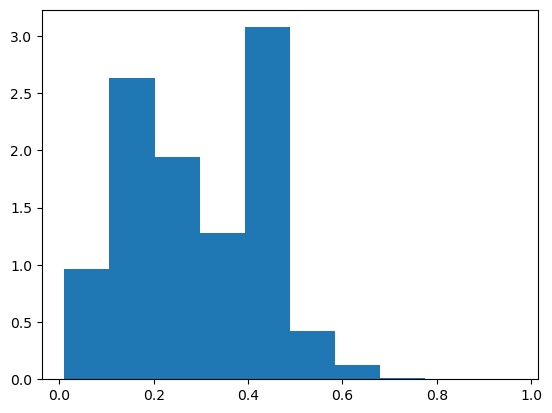

In [103]:
import warnings
warnings.filterwarnings("ignore")

train, valid = preprocessing()
pred = ncf_model(train, valid, epoch = 1)
plt.hist(pred, density = True)
plt.show()

# Model

In [104]:
def dlrm_model(train, valid):
    model_fb = mm.DLRMModel(
        train.schema,
        embedding_dim = 64,
        top_block = mm.MLPBlock([128, 64, 32]),
        bottom_block = mm.MLPBlock([128, 64]),
    )

    model_fb.compile(optimizer = keras.optimizers.Adam(learning_rate = .0175), metrics=[mm.RecallAt(5), mm.NDCGAt(5)])
    model_fb.fit(train, batch_size = 1024, epochs = 1)
    print(model_fb.evaluate(valid, batch_size = 1024, return_dict = True))

In [105]:
dlrm_model(x1, x2)

UnboundLocalError: cannot access local variable 'model_output_cls' where it is not associated with a value

In [ ]:
preds_2 = model_fb.predict(valid, batch_size = 1024)
plt.hist(preds_2, density = True)